In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score

In [7]:
# 1. Load data
df = pd.read_csv('sales_data_sample.csv', encoding='unicode_escape')
print(df.shape)


(2823, 25)


In [8]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [10]:
# 2. Drop unused columns
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(columns=[c for c in to_drop if c in df.columns])

In [11]:
#Check for null values
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [12]:
# 3. Select numeric columns only
df_numeric = df.select_dtypes(include=['int64', 'float64']).copy()
print("Numeric columns:", df_numeric.columns.tolist())

Numeric columns: ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'MSRP']


In [13]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

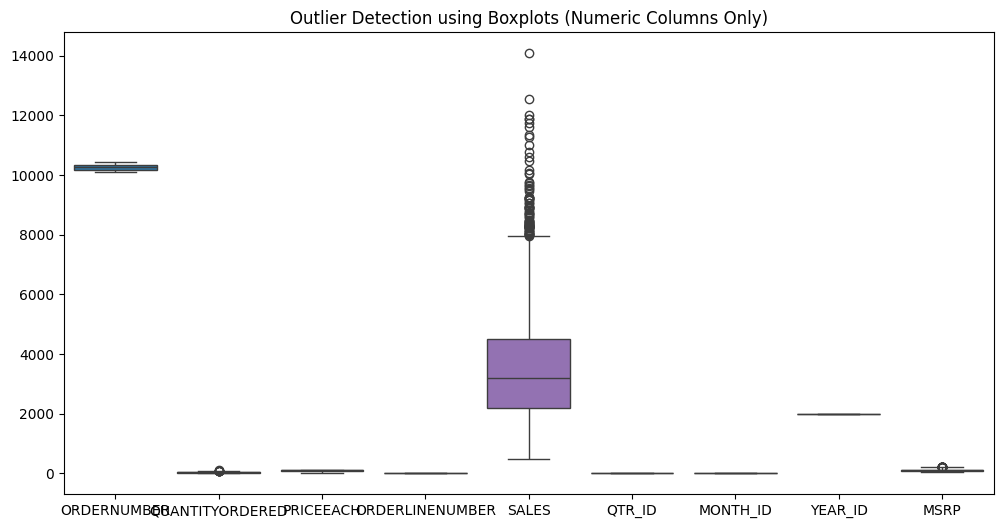

In [14]:
# 4. Visualize boxplots (optional)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_numeric)
plt.title("Outlier Detection using Boxplots (Numeric Columns Only)")
plt.show()

In [15]:
# 5. Detect and cap outliers using IQR (create df_capped)
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Clip each column to [lower, upper]
df_capped = df_numeric.clip(lower=lower, upper=upper, axis=1)
print("Applied clipping to numeric features to handle outliers.")


Applied clipping to numeric features to handle outliers.


In [16]:
# 6. Normalize (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_capped)
df_normalized = pd.DataFrame(X_scaled, columns=df_capped.columns)
display(df_normalized.head())


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
0,-1.647947,-0.526907,0.596978,-1.057059,-0.374413,-1.427039,-1.392909,-1.16517,-0.141341
1,-1.495888,-0.110427,-0.114450,-0.347015,-0.435116,-0.596243,-0.572337,-1.16517,-0.141341
2,-1.354689,0.618413,0.549384,-1.057059,0.210870,0.234553,-0.025289,-1.16517,-0.141341
3,-1.235214,1.034894,-0.019759,-0.110334,0.131372,0.234553,0.248235,-1.16517,-0.141341
4,-1.083154,1.451374,0.810158,1.783116,0.973809,1.065350,0.795284,-1.16517,-0.141341


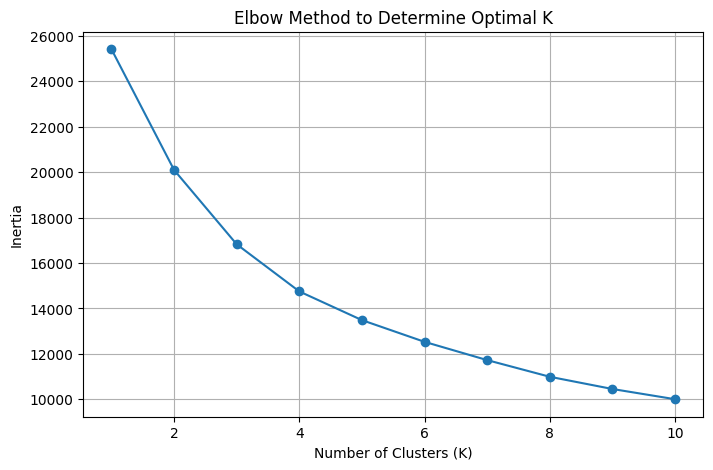

In [17]:
# 7. Elbow method (inertia) to choose K
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method to Determine Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [18]:
# 8. Silhouette scores for K = 2..10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"K = {k} → Silhouette Score = {sil:.4f}")

K = 2 → Silhouette Score = 0.2154
K = 3 → Silhouette Score = 0.1976
K = 4 → Silhouette Score = 0.2077
K = 5 → Silhouette Score = 0.1874
K = 6 → Silhouette Score = 0.1938
K = 7 → Silhouette Score = 0.1910
K = 8 → Silhouette Score = 0.1851
K = 9 → Silhouette Score = 0.1843
K = 10 → Silhouette Score = 0.1864


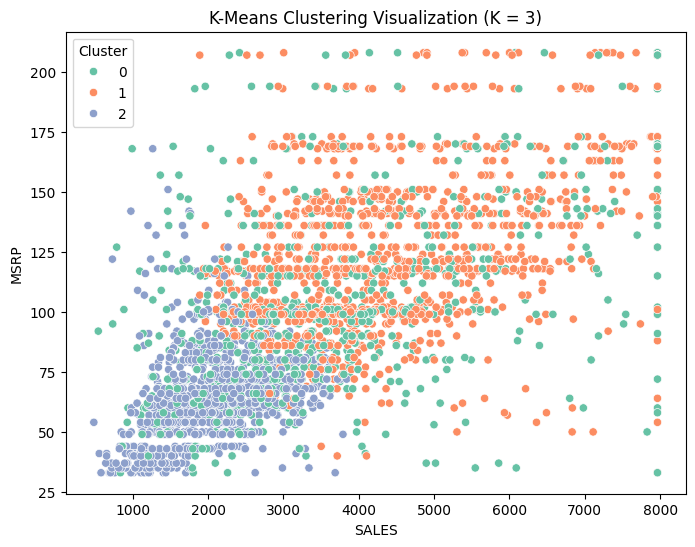

In [19]:
# 9. Visualize clusters for chosen K (example K=3)
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Make sure the columns SALES and MSRP exist before plotting
if 'SALES' in df_capped.columns and 'MSRP' in df_capped.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=df_capped['SALES'],
        y=df_capped['MSRP'],
        hue=labels,
        palette='Set2',
        legend='full'
    )
    plt.title(f"K-Means Clustering Visualization (K = {chosen_k})")
    plt.xlabel("SALES")
    plt.ylabel("MSRP")
    plt.legend(title='Cluster')
    plt.show()
else:
    print("SALES or MSRP column not found in numeric columns; cannot plot SALES vs MSRP.")